# **MVP Machine Learning e Analytics**

**Nome:** Micheline Carvalho Barroso Pereira

**Matrícula:** 4052024001925

**Dataset:** [AI vs Human Content Detection](https://raw.githubusercontent.com/Micheline-code/pos-ciencia-de-dados-analytics-sprint-3/main/ai_human_content_detection_dataset.csv)

# **1) Escopo, objetivo e definição do problema**

**Contexto e Problema**

Com o avanço e a popularização da Inteligência Artificial (IA), a distinção entre textos criados por humanos e aqueles gerados por ferramentas inteligentes tornou-se necessária e relevante. Esse cenário não apenas impacta a autenticidade da produção intelectual humana, como também a responsabilidade pela informação. A capacidade de identificar o tipo de autor de um texto é crucial para proteger a produção intelectual e, ao mesmo tempo, mitigar a disseminação de informações enganosas.

**Objetivo e Aplicação**

Utilizando dados tabulares, extraídos de diversas categorias de textos, o objetivo deste trabalho é desenvolver um **modelo de classificação binária supervisionada** capaz de diferenciar textos gerados por IA de textos escritos por humanos.

O valor prático desse modelo pode ser compreendido a partir dos interesses de diferentes grupos de usuários:

* **Para Educadores:** Permite a garantia da autenticidade nos trabalhos e pesquisas, preservando a integridade do processo de aprendizado e avaliação;

* **Para Gestores de Plataformas de Conteúdo:** Ajuda a manter a credibilidade e a qualidade editorial, combatendo a proliferação de spam e fake news geradas em escala;

* **Para o Público em Geral:** Oferece uma ferramenta para que o usuário final possa tomar decisões de forma segura, na medida em que conhece o autor dos conteúdos textuais utilizados como referência.

# **2) Reprodutibilidade e ambiente**

Consolida todas as importações de bibliotecas necessárias para o carregamento inicial do dataset *AI vs Human Content Detection Dataset*, análise, visualização dos dados e pré-processamento, bem como modelagem, treinamento, teste e análise dos resultados da classificação supersionada.

Além disso, será definida uma  SEED (semente) fixa para inicializar o gerador de números aleatórios e garantir a reprodutibilidade, ou seja, que a sequência de números aleatórios gerados seja sempre a mesma.

In [ ]:
# Setup Básico

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms
import random
import numpy as np
import time
import math
import warnings

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV, cross_val_score, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score, log_loss, average_precision_score, classification_report
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier

from sentence_transformers import SentenceTransformer

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from scipy.stats import randint, uniform, loguniform

# Desabilita apresentação de mensagens do tipo warning
warnings.filterwarnings("ignore")

# Reprodutibilidade

SEED = 42
np.random.seed(SEED)
random.seed(SEED)


## 2.1 Dependências

In [ ]:
# Dependências

!pip install gensim
from gensim.models import Word2Vec

!pip install category_encoders
from category_encoders import TargetEncoder

## 2.2 Funções Python para Word2Vec

In [ ]:
class Word2VecAverager(BaseEstimator, TransformerMixin):

    def __init__(self, vector_size=100, window=5, min_count=5, workers=4):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.workers = workers
        self.model = None
        self.w2v_keys = None

    def fit(self, X, y=None):
        # Tokenização e Lowercase (essencial para limpeza dos embeddings)
        sentences = [text.lower().split() for text in X]

        # Treinamento do modelo Word2Vec
        self.model = Word2Vec(
            sentences=sentences,
            vector_size=self.vector_size,
            window=self.window,
            min_count=self.min_count,
            workers=self.workers
        )
        self.w2v_keys = set(self.model.wv.key_to_index.keys())
        return self

    def transform(self, X):
        def document_vector(doc):
            # Filtra e pega os vetores das palavras que o modelo conhece
            words = [word for word in doc.lower().split() if word in self.w2v_keys]
            if words:
                # Calcula a média (o vetor do documento)
                return np.mean(self.model.wv[words], axis=0)
            else:
                # Caso extremo: documento vazio ou só com palavras raras
                return np.zeros(self.vector_size)

        return np.array([document_vector(text) for text in X])

# **3) Carga dos Dados**

## Seleção de Dados

O conjunto de dados ***AI vs Human Content Detection*** está disponível na plataforma Kaggle (https://www.kaggle.com/datasets/pratyushpuri/ai-vs-human-content-detection-1000-record-in-2025).

Este conjunto de dados sintético foi projetado para tarefas de classificação  binária em aprendizado de máquina. Ele contém amostras de texto rotuladas para detecção de conteúdo gerado por IA versus conteúdo escrito por humanos, com características linguísticas e estilísticas abrangentes, extraídas de cada amostra.

## Licença

O dataset ***AI vs Human Content Detection*** está disponível sob a [Apache License 2.0](https://www.apache.org/licenses/LICENSE-2.0).

© 2025 Pratyush Puri. Licenciado sob a Apache License, Version 2.0.



In [ ]:
# Carga dos dados a partir de uma URL em um repositório público do GitHub.

# URL do CSV (ai_human_content_detection_dataset.csv, também disponível na plataforma Kaggle)
url = "https://raw.githubusercontent.com/Micheline-code/pos-ciencia-de-dados-analytics-sprint-3/main/ai_human_content_detection_dataset.csv"

# Carrega o dataset
df = pd.read_csv(url)

# **4) Análise Exploratória**

A Análise Exploratória de Dados (EDA) é uma etapa fundamental que diagnostica as características do dataset, garantindo que o modelo seja treinado com dados de qualidade. Ela é composta por atividades como análise de nulos, que assegura a integridade dos dados, e análise de balanceamento, que previne que o modelo ignore classes minoritárias em tarefas de classificação.

A análise descritiva complementa a EDA ao revelar estatisticamente a distribuição, o comportamento e a correlação entre as features. Isso permitirá a aplicação correta de ações de pré-processamento, como escalonamento e remoção de redundâncias.

## **Atributos**

O dataset *AI vs Human Content Detection* representa uma grande coleção de textos com diferentes tipos de conteúdo, 1.367 amostras e 17 atributos.

### Descrições

- **text_content:** Conteúdo textual sendo analisado. É a principal variável do conjunto de dados – corresponde ao texto bruto que será avaliado pelo modelo;

- **content_type:** Categoria ou gênero do conteúdo textual, como artigo acadêmico, redação, texto criativo, notícia, blog, rede social, artigo e avaliação de produto. Trata-se de uma variável categórica com 8 tipos distintos;

- **word_count:** Contagem de Palavras. Pode variar desde postagens curtas em redes sociais até artigos mais longos;

- **character_count:** Contagem de Caracteres, incluindo espaços. Apresenta forte correlação com o número de palavras (word_count);

- **sentence_count:** Contagem de Sentenças. Essa variável é usada para calcular o comprimento médio das frases;

- **lexical_diversity:** Diversidade Léxica. Proporção de palavras únicas em relação ao total de palavras no texto, onde valores mais altos indicam um vocabulário mais diverso;

- **avg_sentence_length:** Tamanho Médio da Sentença. Calculado como a razão entre *word_count* e *sentence_count*;

- **avg_word_length:** Tamanho Médio da Palavra (em número de caracteres). Indica a complexidade do vocabulário utilizado;

- **punctuation_ratio:** Proporção de Pontuação. Mede a densidade de pontuação no texto;

- **flesch_reading_ease:** Facilidade de Leitura de *Flesch*. Quanto maior o valor, mais fácil o texto é de ler;

- **gunning_fog_index:** Índice de Névoa de *Gunning*. Representa o nível de escolaridade necessário para compreender o texto;

- **grammar_errors:** Erros de Gramática. Representa a contagem total de erros encontrados na escrita;

- **passive_voice_ratio:** Proporção de Voz Passiva. Indica o grau de uso de construções passivas;

- **predictability_score:** Pontuação de Previsibilidade. Valores mais altos indicam padrões mais repetitivos ou fáceis de prever;

- **burstiness:** Explosividade. Medida de variação no comprimento das frases, onde valores maiores indicam maior variação entre frases curtas e longas;

- **sentiment_score:** Pontuação de Sentimento. Reflete a polaridade do sentimento presente no texto. Varia normalmente entre -1 (negativo) e +1 (positivo), embora possa haver valores nulos;

- **label:** Variável alvo da tarefa de classificação. Indica se o texto foi gerado por uma IA (1) ou por um ser humano (0). Trata-se de uma variável binária.

### Tipos

- Atributos de tipo inteiro (int64): *word_count, character_count, sentence_count, grammar_errors, label*;

- Atributos de tipo ponto flutuante (float64): *lexical_diversity, avg_sentence_length, avg_word_length, punctuation_ratio, flesch_reading_ease, gunning_fog_index, passive_voice_ratio, predictability_score, burstiness, sentiment_score*;

- Atributos de tipo categórico (object): *text_content, content_type*.

### Categorias

- **Métricas de Texto:** *word_count, character_count, sentence_count*;

- **Características Linguísticas:** *lexical_diversity, avg_word_length, avg_sentence_length, punctuation_ratio*;

- **Índices de Legibilidade:** *flesch_reading_ease, gunning_fog_index*;

- **Indicadores de Estilo:** *passive_voice_ratio, burstiness, grammar_errors*;

- **Análise de Conteúdo:** *sentiment_score, predictability_score*;

- **Texto Original:** *text content*;

- **Metadados:** *content_type*;

- **Variável Alvo:** *label*.

## **Hipóteses**

**1) Variação no comprimento das frases (*burstiness*):** Textos gerados por IA apresentam frases mais homogêneas, com menos alternância entre sentenças curtas e longas.

**2) Previsibilidade dos padrões linguísticos (*predictability_score*):** Como a IA tende a repetir estruturas e escolhas de palavras, espera-se maior previsibilidade em seus textos.

**3) Diversidade lexical (*lexical_diversity*):** Textos humanos utilizam um vocabulário mais variado, com maior proporção de palavras únicas.

**4) Legibilidade do texto (*flesch_reading_ease* e *gunning_fog_index*):** Textos gerados por IA tendem a ser mais claros, fáceis de ler e exigem menor nível de escolaridade para compreensão.

**5) Ocorrência de erros gramaticais (*grammar_errors*):** Textos humanos apresentam mais erros de gramática, enquanto IAs geralmente produzem redações mais corretas.

**6) Uso da voz passiva (*passive_voice_ratio*):** Humanos utilizam mais construções na voz passiva, enquanto IAs preferem estruturas diretas e objetivas.

**7) Expressão emocional no texto (*sentiment_score*):** Textos humanos apresentam maior variação de sentimentos (polarização positiva ou negativa), enquanto a IA tende a produzir conteúdo mais neutro.

## 4.1) Dimensões do dataset, atributos preditores e variável alvo

In [ ]:
# Visualiza as primeiras linhas
df.head()

In [ ]:
# Visualiza as últimas linhas
df.tail()

In [ ]:
# Mostra as dimensões do dataset
df.shape

In [ ]:
# Calcula e mostra o total de linhas
total = len(df)
print(f"Total de instâncias: {total}")

# Calcula e mostra a quantidade de valores não nulos e o tipo de dado por coluna
print("\nTipos de dados por coluna:\n")
print(df.info())

In [ ]:
# Mapeando os valores de label para descrição de autores
df['autor'] = df['label'].map({0: 'Humano', 1: 'IA'})

#### **Resultados**

Nesta etapa, foi criado o atributo *autor* como uma versão em texto para o atributo *label* (alvo), visando facilitar a legibilidade dos gráficos e dos resultados apresentados na etapa de Análise Exploratória (se `label = 1`, então `autor = IA`; se `label= 0`, então `autor = Humano`).

O atributo *autor* será removido no final da etapa de Análise Exploratória (seção 4).

## 4.2) Análise de Nulos

In [ ]:
# Mostra a quantidade e o percentual de valores nulos por coluna
nulos = df.isnull().sum().to_frame(name='Nulos')
nulos['% Nulos'] = (nulos['Nulos'] / total * 100).round(2)

print(nulos)

In [ ]:
# Exibe visualização matricial da nulidade do dataset original
ms.matrix(df)

In [ ]:
# Remove linhas com valores nulos (neste momento, é criado um novo dataset sem nulos)
df_sem_nulos = df.dropna(how='any')

# Mostra a quantidade de linhas sem nulos
df_sem_nulos.count()

In [ ]:
# Exibe visualização matricial da nulidade do dataset que foi transformado (sem nulos)
ms.matrix(df_sem_nulos)

In [ ]:
# Calcula e imprime a diferença e a proporção de nulos
diferenca_nulos = len(df) - len(df_sem_nulos)
proporcao_nulos= round((diferenca_nulos/1367 * 100),2)

print(f'Diferença entre dataset original e dataset sem nulos: {diferenca_nulos} linhas')

print(f'Proporção de  nulos: {proporcao_nulos}%')


#### **Resultados**

Para o dataset *AI vs Human Content Detection*, observamos que, a nível de coluna, apenas 4 colunas numéricas (*flesch_reading_ease, gunning_fog_index, passive_voice_ratio, sentiment_score*) apresentam nulos e em proporções baixas, que variam de 2,27% a 5,78% (menor que 6%). A variável alvo *label* não possui valores nulos.

Ao removermos todas as 188 linhas com algum valor nulo, chegamos a um dataset com 1.179 linhas, ou seja, 86,2% do original (1.367 linhas). Considerando que todas as colunas numéricas devem ser consideradas nas próximas etapas e, como a proporção de linhas com nulos é de 13,8% (proporção média - de 5% a 20%), a conclusão dessa análise é de que os nulos devem ser tratados na etapa de pré-processamento.

Ressaltamos que o dataset (dataframe) sem nulos foi criado apenas para a análise realizada nessa seção e não será considerado nas próximas etapas desse estudo.

## 4.3) Análise de Balanceamento

In [ ]:
# Análise de Balanceamento da variável alvo

# Contagem absoluta de cada classe
contagem = df['autor'].value_counts()

# Proporção relativa (em percentual) de cada classe
proporcao = df['autor'].value_counts(normalize=True) * 100

# Combina em um único DataFrame
resultado = pd.DataFrame({
    'Contagem': contagem,
    'Proporção (%)': proporcao.round(2)
})

print(resultado)

In [ ]:
# Mostra graficamente quantidade de instâncias por classe (variável alvo)
plt.figure(figsize=(7, 5))

# Gráfico de barras simples para mostrar quantidade de amostras por classe
ax = sns.countplot(x='autor', data=df)
plt.title('Gráfico 1: Distribuição por Autor')
plt.xlabel('Autor')
plt.ylabel('Contagem')

# Adiciona os rótulos de contagem em cima das barras
for p in ax.patches:
    altura = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, altura + 0.5, int(altura),
            ha='center', va='bottom')

plt.show()

#### **Resultados**

O **gráfico 1** mostra que as classes **IA** (`label = 1`) e **Humano** (`label = 0`) prossuem praticamente a mesma proporção (diferença de 1 amostra a mais para a classe **Humano**). Portanto, nenhuma ação de balanceamento será necessária para esse estudo.

## 4.4) Análise Descritiva

### 4.4.1) Estatísticas Descritivas para Dataset Completo


In [ ]:
# Gera estatísticas descritivas básicas para variáveis numéricas do dataset completo
df.describe()

In [ ]:
# Exibe boxplot para dataset completo (variáveis numéricas)
df.plot(kind = 'box', subplots = True, layout = (5,5), sharex = False, sharey = False, figsize = (15,10))
plt.suptitle('Gráfico 2.1: Distribuição dos Valores por Atributos Numéricos para dataset completo (boxplot)', fontsize=14, y=1)
plt.xlabel('Classe (Autor)')
plt.show()

In [ ]:
# Gera density plot para dataset completo (variáveis numéricas)

# Seleciona apenas as colunas numéricas
df_numerico = df.select_dtypes(include=['int64', 'float64'])

# Seleciona colunas com variância diferente de zero
variancias = df_numerico.var()
colunas_variancia = variancias[variancias != 0].index
df_variancia = df[colunas_variancia]

df_variancia.plot(kind = 'density', subplots = True, layout = (5,5), sharex = False, figsize = (15,10))
plt.suptitle("Gráfico 2.2: Distribuição dos Valores por Atributos Numéricos para dataset completo (density plot)", fontsize=14, y=1)
plt.show()

#### **Análise Descritiva de Dados (Dataset Completo)**

A partir da **tabela com dados estatísticos** e dos **gráficos 2.1** e **2.2**, a análise descritiva do dataset completo revelou aspectos relevantes tanto para o desenvolvimento do modelo de classificação quanto para a avaliação das hipóteses levantadas. A seguir, destacam-se os pontos mais significativos.

* ***Burstiness:*** apresentou ampla variação (0,10–0,80), indicando diferenças consistentes no ritmo da escrita. Este atributo tem alto potencial para distinguir estilos humanos, mais irregulares, de textos produzidos por IA.

* ***Predictability_score:*** exibiu distribuição heterogênea, com concentrações em diferentes faixas de valores. Essa dispersão sugere utilidade para identificar padrões de previsibilidade típicos de textos gerados por IA.

* ***Lexical_diversity:*** concentrou-se em níveis elevados (mediana ≈ 0,97), com pouca variação. Embora seja relevante teoricamente, pode ter menor poder discriminativo, devendo ser verificado de forma estratificada por classe.

* ***Flesch Reading Ease* e *Gunning Fog Index* (Legibilidade):** ambos os índices apresentaram ampla amplitude, variando de textos muito difíceis até extremamente simples. Essa variabilidade reforça a adequação desses atributos para identificar diferenças na clareza e complexidade textual entre humanos e IA.

* ***Grammar_errors:*** mostrou distribuição enviesada, com grande concentração em textos sem erros e poucos casos com até dez erros. Essa característica é consistente com a hipótese de que humanos cometem mais falhas gramaticais, enquanto textos de IA tendem a ser mais corretos.

* ***Passive_voice_ratio:*** concentrou-se em torno de 0,15, com variação limitada. O atributo pode ser útil se houver diferenças estatisticamente significativas entre as classes, mas não se mostra forte isoladamente.

* ***Sentiment_score:*** distribuiu-se de forma quase uniforme entre -1 e +1, indicando diversidade de polaridades no corpus. Essa amplitude permite testar a hipótese de que textos humanos apresentam maior tendência a sentimentos extremos, enquanto IAs permanecem mais neutras.

Por outro lado, atributos como tamanho médio das palavras (*avg_word_length*), tamanho médio das sentenças (*avg_sentence_length*) e proporção de pontuação (*punctuation_ratio*) apresentaram distribuições muito concentradas, sugerindo menor relevância isolada para a tarefa de classificação.

### 4.4.2) Estatísticas Descritivas por Classe

In [ ]:
# Gera estatísticas descritivas básicas para variáveis numéricas da classe "Humano" do dataset
df[df['autor'] == 'Humano'].describe()

In [ ]:
# Gera estatísticas descritivas básicas para variáveis numéricas da classe "IA" do dataset
df[df['autor'] == 'IA'].describe()

In [ ]:
# Gera boxplots de atributos numéricos por classe (Humano x IA)

# Lista de atributos numéricos para comparação
numeric_cols = [
    'word_count', 'character_count', 'sentence_count', 'lexical_diversity',
    'avg_sentence_length', 'avg_word_length', 'punctuation_ratio',
    'flesch_reading_ease', 'gunning_fog_index', 'grammar_errors',
    'passive_voice_ratio', 'predictability_score', 'burstiness',
    'sentiment_score'
]

# Configuração para plotar múltiplos gráficos
n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

plt.figure(figsize=(18, 5 * n_rows))
plt.subplots_adjust(hspace=0.4)

for i, col in enumerate(numeric_cols):
    plt.subplot(n_rows, n_cols, i + 1)

    # Gera o boxplot, separando a distribuição pelo atributo autor
    sns.boxplot(x='autor', y=col, data=df)

    plt.title(f'Distribuição de {col} por Autor', fontsize=12)
    plt.xlabel('Autor (Humano vs IA)')
    plt.ylabel(col)

plt.suptitle('Gráfico 2.3: Boxplots Comparativos dos Atributos Numéricos por Classe (Humano x IA)', fontsize=16, y=1.02)
plt.show()

In [ ]:
# Gera density plots de atributos numéricos por classe (Humano x IA)

# Lista de atributos numéricos a serem comparados
numeric_cols = [
    'word_count', 'character_count', 'sentence_count', 'lexical_diversity',
    'avg_sentence_length', 'avg_word_length', 'punctuation_ratio',
    'flesch_reading_ease', 'gunning_fog_index', 'grammar_errors',
    'passive_voice_ratio', 'predictability_score', 'burstiness',
    'sentiment_score'
]

# Configuração para plotar múltiplos gráficos
n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

plt.figure(figsize=(18, 5 * n_rows))
plt.subplots_adjust(hspace=0.4)

for i, col in enumerate(numeric_cols):
    plt.subplot(n_rows, n_cols, i + 1)

    # Gera o Density Plot, separando as curvas pelo atributo 'autor' (Humano x IA)
    sns.kdeplot(data=df, x=col, hue='autor', fill=True, common_norm=False, alpha=.4)

    plt.title(f'Distribuição de {col} por Autor', fontsize=12)
    plt.xlabel(col)
    plt.ylabel('Densidade')

plt.suptitle('Gráfico 2.4: Density Plots Comparativos dos Atributos Numéricos por Classe (Humano x IA)', fontsize=16, y=1.02)
plt.show()

#### **Análise Exploratória de Dados (Humano x IA)**

A partir das **tabelas com dados estatísticos**, e dos **gráficos 2.3** e **2.4** para as classes Humano e IA, percebe-se que a distinção entre textos gerados por IA e textos humanos é primariamente impulsionada por métricas de ritmo e estrutura do texto, enquanto as métricas de legibilidade e diversidade léxica mostram baixo poder discriminativo.

**Atributos com Alto Poder Discriminativo**

* **Variação no Comprimento das Frases (*burstiness*):** O texto Humano apresenta uma média de *burstiness* superior (0.442) à do texto gerado por IA (0.412), indicando um ritmo de escrita mais irregular (alternância de frases curtas e longas).

* **Previsibilidade do Padrão (*predictability_score*):** O texto Humano exibe uma pontuação de previsibilidade superior (63.83) à da IA (61.72). Isso contraria a hipótese inicial de que a IA seria mais previsível, sugerindo que os padrões de escrita humana neste corpus são mais recorrentes.

**Atributos com Baixo Poder Discriminativo**

* **Diversidade e Complexidade (*lexical_diversity*, *avg_word_length*, *avg_sentence_length*):** A Diversidade Lexical, o Tamanho Médio da Palavra e o Tamanho Médio da Sentença se sobrepõem quase completamente, sugerindo que a IA e o Humano usam vocabulários e estruturas de frases com similar complexidade.

* **Legibilidade e Voz Passiva (*flesch_reading_ease*, *gunning_fog_index*, *passive_voice_ratio*):** As métricas de Facilidade de Leitura de Flesch, o Índice de Névoa de Gunning e a Proporção de Voz Passiva têm médias praticamente idênticas, invalidando as hipóteses de que a IA produziria textos mais claros ou com menos voz passiva.

* **Sentimento (*sentiment_score*):** O Sentiment Score tem distribuição e variância muito semelhantes, indicando que a polaridade emocional não é um forte fator de distinção.

**Observações Adicionais**

* **Erros Gramaticais (*grammar_errors*):** Embora as médias sejam próximas, a distribuição de erros gramaticais para o grupo Humano apresenta uma cauda direita mais longa, indicando uma maior ocorrência de textos com um número elevado de erros em comparação com a IA, que tende a concentrar-se em textos perfeitos (zero erros).

* **Tamanho do Conteúdo (*word_count*, *character_count*, *sentence_count*):** As contagens de palavras, caracteres e sentenças têm distribuições sobrepostas, mas a IA apresenta uma ligeira tendência a textos mais longos.

### 4.4.3) Matriz de Correlação por Classe

In [ ]:
# Filtra instâncias do autor Humano
df_humano = df[df['autor'] == 'Humano'].copy()

# Remove a coluna label
df_humano_sem_label = df_humano.drop(['label'], axis=1)

# Calcula correlação de Pearson para o dataset completo
correlacoes_numericos_humano = df_humano_sem_label.corr(method='pearson', numeric_only=True)

correlacoes_numericos_humano

In [ ]:
# Gera matriz de correlação para autor Humano

# Cria a figura e o eixo com tamanho ajustado
plt.figure(figsize=(15, 12))

# Gera o heatmap com anotações e nomes de eixos legíveis
sns.heatmap(
    correlacoes_numericos_humano,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.5,
    cbar_kws={'label': 'Coeficiente de Correlação'}
)

# Ajusta o layout para evitar sobreposição
plt.title('Matriz 1: Correlação entre Atributos Numéricos para autor Humano', fontsize=16)
plt.xticks(rotation=90, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()

# Exibe o gráfico
plt.show()

In [ ]:
# Filtra instâncias do autor IA
df_ia = df[df['autor'] == 'IA'].copy()

# Remove a coluna label
df_ia_sem_label = df_ia.drop(['label'], axis=1)

# Calcula correlação de Pearson para o dataset completo
correlacoes_numericos_ia = df_ia_sem_label.corr(method='pearson', numeric_only=True)

correlacoes_numericos_ia

In [ ]:
# Gera matriz de correlação para autor IA

# Cria a figura e o eixo com tamanho ajustado
plt.figure(figsize=(15, 12))

# Gera o heatmap com anotações e nomes de eixos legíveis
sns.heatmap(
    correlacoes_numericos_ia,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.5,
    cbar_kws={'label': 'Coeficiente de Correlação'}
)

# Ajusta o layout para evitar sobreposição
plt.title('Matriz 2: Correlação entre Atributos Numéricos para autor IA', fontsize=16)
plt.xticks(rotation=90, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()

# Exibe o gráfico
plt.show()

#### **Análise Comparativa Consolidada da Correlação (Humano x IA)**

A comparação das **Matrizes de Correlação 1** e **2** confirma uma alta redundância entre os atributos e aponta para a necessidade de simplificar o conjunto de features antes da modelagem.

**Alta Redundância (Multicolinearidade)**

As correlações mais fortes (acima de 0.80) indicam que diversos atributos medem a mesma dimensão, sendo redundantes. Para evitar problemas de multicolinearidade em modelos e para simplificar a pipeline, a melhor prática seria manter apenas um atributo de cada grupo:

* **Tamanho do Texto:** O número de palavras, caracteres e sentenças está quase perfeitamente correlacionado (0.99). Neste caso, pode-se manter apenas o *word_count*.

* **Legibilidade e Complexidade:** Os índices de legibilidade (*flesch_reading_ease* e *gunning_fog_index*) e o *avg_word_length* estão fortemente correlacionados (entre -0.75 e -0.88). Pode-se manter o *flesch_reading_ease* (ou *gunning_fog_index*) e descartar os outros dois.

* **Comprimento de Frases e Pontuação:** A correlação inversa entre *avg_sentence_length* e *punctuation_ratio* (entre -0.82 e -0.88) sugere que ambos refletem o espaçamento dos sinais de pontuação. É indicado manter apenas o *avg_sentence_length*.

**Relações Chave para Discriminação**

Duas relações merecem atenção, pois são importantes para o poder preditivo do modelo:

* **Previsibilidade vs. Ritmo (*predictability_score* e *burstiness*):** Esses dois atributos, que se mostraram os melhores discriminadores na Análise de Distribuição, possuem uma correlação alta, mas não perfeita (0.70). Eles devem ser mantidos juntos, pois a combinação de ambos é mais poderosa.

* **Diferença de Estrutura (*word_count* e *grammar_errors*):** A correlação entre o tamanho do texto e os erros gramaticais é mais forte no grupo IA (0.37) do que no grupo Humano (0.30). Essa diferença de grau de dependência entre as classes é uma informação valiosa que o modelo pode usar para a classificação.


In [ ]:
# Remoção da feature autor
df = df.drop(columns=['autor'])

## 4.5) Resultados da Análise Exploratória

#### **Resultados**

A partir das análises exploratórias realizadas nessa seção, além de conhecer os dados em maior profundidade, foram identificadas sugestões de atividades para a etapa de pré-processsamento.

* **Análise de Nulos:** Imputação do valor da mediana para valores nulos;

* **Análise de Balanceamento**: Dataset já se encontra balanceado;

* **Análise Descritiva:** Considerando todos os dados estatísticos, gráficos (boxplots, density plots) e matrizes de correlação, algumas ações foram propostas:

> * Relações Chave para Discriminação: Manter atributos com potencial de colaborar para o poder preditivo do modelo;

> * Simplificação do Conjunto de Atributos: Aplicar as remoções baseadas na alta redundância;

> * Tratamento Categórico: Aplicar One-Hot Encoding na variável *content_type*;

>* Vetorização do Texto: Definir a estratégia de PLN para a variável *text_content*.






#### **Conclusões acerca da Diferença de Escrita (Humano x IA)**

**Hipóteses**

1) **Variação de Frases	(*burstiness*):** O ritmo humano é mais irregular,  Humano (0.442) maior que IA (0.412), VALIDADA.

2) **Previsibilidade	(*predictability_score*):** Textos humanos são mais previsíveis neste corpus, Humano (63.83) maior que IA (61.72),	REFUTADA/INVERSA.

3) **Diversidade Lexical (*lexical_diversity*):**	A diferença é insignificante, Humano (0.969) e IA (0.967) muito próximas, NÃO VALIDADA.

4) **Legibilidade	(*flesch_reading_ease*):** As médias são idênticas, Humano (52.18) e IA (52.18), NÃO VALIDADA.

5) **Erros Gramaticais (*grammar_errors*):** Média similar, mas gráficos mostram que humanos possuem mais textos com muitos erros, Humano (1.56) e IA (1.52) próximas, PARCIALMENTE VALIDADA.

6) **Uso da Voz Passiva	(*passive_voice_ratio*):**	As médias são idênticas, Humano (0.150) e IA (0.151),	NÃO VALIDADA.

7) **Expressão Emocional (*sentiment_score*):**	A variação da IA é ligeiramente maior, Humano (desvio padrão = 0.579) e IA (desvio padrão = 0.598) próximas,	NÃO VALIDADA.



# **5) Modelagem: Criação de Cenários**

A etapa de modelagem foi estruturada em uma série de cenários de teste incrementais para avaliar a contribuição de diferentes conjuntos de features na performance preditiva. O objetivo principal desta abordagem é isolar o impacto da engenharia de features e, posteriormente, da inclusão do Processamento de Linguagem Natural (PLN), identificando o ponto exato em que a distinção entre texto gerado por IA e humano se torna mais robusta.

Iniciamos com um baseline focada apenas em features numéricas existentes (Cenário 1) e evoluímos gradualmente. Nos Cenários 2 e 3, aplicamos rigorosa seleção de atributos e engenharia de features para otimizar a matriz de dados originais. Finalmente, o Cenário 4 representa o foco principal do estudo, integrando os atributos mais discriminatórios com as features de texto (text_content e content_type), visando capturar a complexidade da linguagem através de técnicas de PLN, como o TF-IDF.

##**Cenários:**

* **Cenário 1 (baseline):** Todos os campos do dataset original (sem *text_content* e *content_type*);

* **Cenário 2:** Campos selecionados após análise exploratória (sem *text_content* e *content_type*), com foco em remover a alta redundância (multicolinearidade) e manter as métricas com potencial discriminatório;

* **Cenário 3:** Campos selecionados, após análise exploratória (sem *text_content* e *content_type*), são combinados com novos campos, resultantes de engenharia de features;

* **Cenário 4:** Campos selecionados, com foco em maior potencial discriminatório (*burstiness*, *predictability_score*, *lexical_diversity*), são combinados com campos dos tipos texto e categórico (*text_content* e *content_type*);

* **Cenário 5:** Somente com o campo do tipo texto (*text_content*) para ser usado com `TF-IDF`;

* **Cenário 6:** Somente com o campo do tipo texto (*text_content*) para ser usado com `Word2Vec`;

* **Cenário 7:** Somente com o campo do tipo texto (*text_content*) para ser usado com `BERT`;

* **Cenário 8:** Campos selecionados, com foco em maior potencial discriminatório (*burstiness*, *predictability_score*, *lexical_diversity*), são combinados com campos do tipo texto (*text_content*) e do tipo categórico (*content_type*), sendo esse último selecionado para transformação *target encoder*.



In [ ]:
# Copia dataset original para possibilidade de uso posterior
df_original = df.copy()
print(df_original.columns)

In [ ]:
# CENÁRIO 1 (dataset completo)

# Copia dataset original
df_cenario_1 = df_original.copy()

# Remove colunas de tipo categórico
colunas_a_remover = ['text_content', 'content_type']
df_cenario_1.drop(colunas_a_remover, axis=1, inplace=True)

print(df_cenario_1.columns)

In [ ]:
# CENÁRIO 2 (remoção de campos texto e de campos redundantes)

# Copia dataset original
df_cenario_2 = df_original.copy()

# Remove colunas indicadas na análise exploratória
colunas_a_remover = ['text_content', 'content_type', 'character_count', 'sentence_count', 'punctuation_ratio', 'avg_word_length', 'gunning_fog_index', 'lexical_diversity', 'grammar_errors', 'passive_voice_ratio', 'sentiment_score']

# Modifica o DataFrame
df_cenario_2.drop(colunas_a_remover, axis=1, inplace=True)

print(df_cenario_2.columns)


In [ ]:
# CENÁRIO 3 (remoção de campos texto, remoção de campos redundantes e criação de novas features)

# Copia dataset original
df_cenario_3 = df_original.copy()

# CRIAÇÃO DE NOVA FEATURES

# Índice de Disparidade (Burstiness / Previsibilidade)
# Mede a relação entre a variação de ritmo (Burstiness) e a repetição de padrões (Predictability)
# Adiciona 1 ao denominador para evitar divisão por zero
df_cenario_3['disparity_index'] = df_cenario_3['burstiness'] / (df_cenario_3['predictability_score'] + 1)

# Complexidade/Clareza Ponderada
# Combina a dificuldade de leitura (Gunning Fog Index) com a variedade de vocabulário
# Adiciona 0.001 ao denominador para evitar divisão por zero, já que a Diversidade Lexical é próxima de 1
df_cenario_3['weighted_complexity'] = df_cenario_3['flesch_reading_ease'] / (df_cenario_3['lexical_diversity'] + 0.001)

# Densidade de Erros por Palavra
# Cria uma métrica relativa de qualidade gramatical, útil para normalizar pela contagem de palavras
# Adiciona 1 ao denominador para evitar divisão por zero
df_cenario_3['error_density'] = df_cenario_3['grammar_errors'] / (df_cenario_3['word_count'] + 1)

# Remove colunas indicadas na análise exploratória
colunas_a_remover = ['text_content', 'content_type', 'character_count', 'sentence_count', 'punctuation_ratio', 'avg_word_length', 'gunning_fog_index', 'lexical_diversity', 'grammar_errors', 'passive_voice_ratio', 'sentiment_score']

# Modifica o DataFrame
df_cenario_3.drop(colunas_a_remover, axis=1, inplace=True)

print(df_cenario_3.columns)


In [ ]:
# CENÁRIO 4 (seleciona campos de maior potencial discriminatório, campo categórico e campo texto)

# Copia dataset original
df_cenario_4 = df_original.copy()

# Seleciona colunas conforme resultados da análise exploratória
df_cenario_4 = df_cenario_4[['burstiness', 'predictability_score', 'text_content', 'content_type', 'label']].copy()

print(df_cenario_4.columns)

In [ ]:
# CENÁRIO 5 (seleciona campo texto para TF-IDF)

# Copia dataset original
df_cenario_5 = df_original.copy()

# Seleciona colunas conforme resultados da análise exploratória
df_cenario_5 = df_cenario_5[['text_content', 'label']].copy()

print(df_cenario_5.columns)

In [ ]:
# CENÁRIO 6 (seleciona campo texto para Word2Vec)

# Copia dataset original
df_cenario_6 = df_original.copy()

# Seleciona colunas conforme resultados da análise exploratória
df_cenario_6 = df_cenario_6[['text_content', 'label']].copy()

print(df_cenario_6.columns)

In [ ]:
# CENÁRIO 7 (seleciona campo texto para BERT)

# Copia dataset original
df_cenario_7 = df_original.copy()

# Seleciona colunas conforme resultados da análise exploratória
df_cenario_7 = df_cenario_7[['text_content', 'label']].copy()

print(df_cenario_7.columns)

In [ ]:
# CENÁRIO 8 (seleciona campos de maior potencial discriminatório, campo texto e, especialmente, categórico para aplicar transformação target encoder)

# Copia dataset original
df_cenario_8 = df_original.copy()

# Seleciona colunas conforme resultados da análise exploratória
df_cenario_8 = df_cenario_8[['burstiness', 'predictability_score', 'text_content', 'content_type', 'label']].copy()

print(df_cenario_8.columns)

# **6) Modelagem: definição do cenário, target, atributos preditores e divisão dos dados**

In [ ]:

# Definição do cenário a ser testado
# Opções: df_cenario_1, df_cenario_2, df_cenario_3, df_cenario_4, df_cenario_5, df_cenario_6, df_cenario_7, df_cenario_8
df = df_cenario_8.copy()

# CONFIGURAÇÃO
target = "label"

# DEFININDO FEATURES
features = [c for c in df.columns if c not in [target, "timestamp"]]
print("Target:", target)
print("Número de Features:", len(features))

# Lista completa de features
print("Lista de Features:", features)

# TREINO / TESTE
X = df[features].copy()
y = df[target].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
print("Treino:", X_train.shape, "| Teste:", X_test.shape)

## 6.1) Geração e Carga de Vetores (Embeddings BERT) - Cenário 7

In [ ]:
# ESTE CÓDIGO DEVE SER EXECUTADO APENAS UMA VEZ PARA GERAR OS ARQUIVOS .NPY

# Neste ponto, X_train e X_test devem ter sido definidos

# Carrega o Modelo (usando DistilBERT, mais rápido que o BERT)
# O modelo 'all-MiniLM-L6-v2' gera vetores de 384 dimensões
# O modelo 'all-mpnet-base-v2' gera vetores de 768 dimensões
model_name = 'all-mpnet-base-v2'
model = SentenceTransformer(model_name)

print(f"Gerando embeddings para o {model_name}...")

# Gera os Embeddings (para Treino e Teste)
# X_train['text_content'].tolist() garante que o modelo receba uma lista de strings
X_train_embeddings = model.encode(X_train['text_content'].tolist(), show_progress_bar=True)
X_test_embeddings = model.encode(X_test['text_content'].tolist(), show_progress_bar=True)

# 3. Salva os Arrays (evita reprocessamento)
np.save('X_train_embeddings.npy', X_train_embeddings)
np.save('X_test_embeddings.npy', X_test_embeddings)

print("Embeddings salvos com sucesso!")

# A partir daqui, os arquivos .npy serão usados na pipeline

In [ ]:
# ESTE CÓDIGO DEVE SER EXECUTADO PARA CARREGAR OS ARQUIVOS .NPY
# Carrega os arrays salvos (assume que estão no mesmo diretório)
X_train_BERT = np.load('X_train_embeddings.npy')
X_test_BERT = np.load('X_test_embeddings.npy')

# O alvo (y) permanece o mesmo
y_train_BERT = y_train
y_test_BERT = y_test

print(f"Dados de Treino BERT carregados. Formato: {X_train_BERT.shape}")

# **7) Modelagem: separação de variáveis, transformações, pré-processadores, algoritmos, seletores de features e pipelines**


## 7.1) Separação de Variáveis

In [ ]:
# SEPARAÇÃO DE VARIÁVEIS (features)

# VARIÁVEIS CATEGÓRICAS

# Feature categórica selecionada para teste (Cenário 4)
categorical_features = ['content_type']

# Sem feature categórica selecionada (Cenários 1, 2, 3, 5 e 6)
#categorical_features = ''

print("Features Categóricas:", categorical_features)

# VARIÁVEIS TEXTUAIS

# Feature texto selecionada para teste (Cenários 4, 5 e 6)
textual_features = ['text_content']

# Sem feature texto selecionada (Cenários 1, 2 e 3)
#textual_features = ''

print("Features Textuais:", textual_features)

# VARIÁVEIS NUMÉRICAS

# Features numéricas selecionadas para teste (Cenários 1, 2, 3 e 4)
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Sem features numéricas selecionadas (Cenários 5 e 6)
#numerical_features = ''

print("Features Numéricas:", numerical_features)


## 7.2) Definição de Transformações

In [ ]:
# TRANSFORMAÇÕES

# NUMÉRICAS (Cenários 1, 2, 3 e 4)
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


# CATEGÓRICAS (Cenário 4)
categorical_transformer_onehot = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


# CATEGÓRICAS (Cenário 8)
categorical_transformer_target = Pipeline(steps=[
    ('target_enc', TargetEncoder(cols=['content_type']))
])


# TEXTO: Transformador de texto - PLN: TF-IDF (Cenários 4 e 5)
textual_transformer = Pipeline(steps=[
    ('ravel', FunctionTransformer(lambda x: x.squeeze().astype(str), validate=False)),
    ('tfidf', TfidfVectorizer(
        stop_words='english',
        max_features=15000,
        ngram_range=(1, 2)
    ))
])


# TEXTO: Transformador de texto - PLN: Word2Vec, Embeddings (Cenário 6)
textual_transformer_w2v = Pipeline(steps=[
    ('ravel', FunctionTransformer(lambda x: x.squeeze().astype(str), validate=False)),
    # Definidas 100 features densas, adequadas para modelos tradicionais
    ('w2v_avg', Word2VecAverager(vector_size=100, min_count=2, window=5))
])


## 7.3) Definição de Pré-Processadores

In [ ]:
# PRÉ-PROCESSADORES

# NUMÉRICO (Cenários 1, 2 e 3)
num_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features)
    ]
)


# NUMÉRICO, CATEGÓRICO e TEXTO (Cenário 4)
num_cat_text_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        ('text', textual_transformer, textual_features)
    ],
    remainder='drop'
)


# NUMÉRICO, CATEGÓRICO e TEXTO (Cenário 8)
num_cat_text_preprocessor_target = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer_target, categorical_features),
        ('text', textual_transformer, textual_features)
    ],
    remainder='drop'
)


# TEXTO: Pré-processador para TF-IDF (Cenário 5)
pure_text_preprocessor = ColumnTransformer(
    transformers=[
        ('texto', textual_transformer, textual_features)
    ],
    remainder='drop'
)


# TEXTO: Pré-processador para Word2Vec (Cenário 6)
pure_text_preprocessor_w2v = ColumnTransformer(
    transformers=[
        ('texto', textual_transformer_w2v, textual_features) # ['text_content']
    ],
    remainder='drop'
)


## 7.4) Definição de Algoritmos

### **Descrição dos Classificadores por Família**

**1) Lineares: LogisticRegression e LinearSVC**

Modelos lineares que separam classes usando um hiperplano. *LogisticRegression* estima probabilidades via função logística, enquanto *LinearSVC* maximiza a margem entre classes. Ambos lidam bem com alta dimensionalidade, especialmente dados esparsos, e usam regularização para controlar overfitting e features irrelevantes.

**2) Baseado em vizinhos: KNeighborsClassifier**

Classifica cada ponto pela maioria das classes de seus *k* vizinhos mais próximos. Simples e intuitivo, mas sensível à escala e à alta dimensionalidade, funcionando melhor quando padrões locais são claros.

**3) SVM: SVC**

Encontra o hiperplano que maximiza a margem entre classes, podendo usar kernels lineares ou não lineares. Bom para separar classes complexas, mas sensível a features irrelevantes e dimensionalidade.

**4) Ensemble de árvores: RandomForestClassifier**

Constrói múltiplas árvores de decisão sobre subconjuntos de dados e features, votando pela classe majoritária. Robusto a features irrelevantes, tolerante a ruído, captura interações complexas e fornece importância das variáveis.

In [ ]:
# ALGORITMOS
reg_log = ('LR', LogisticRegression(max_iter=200, random_state=SEED))
knn = ('KNN', KNeighborsClassifier())
svm = ('SVM', SVC(probability=True, random_state=SEED))
random_forest = ('RF', RandomForestClassifier(random_state=SEED))
linear_svc = ('LSVC', LinearSVC(random_state=SEED, dual='auto', max_iter=10000))

## 7.5) Definição de Seletores de Features

Na otimização de parâmetros com *GridSearch* e *RandomizedSearchCV*, **deve-se incluir o seletor *SelectKBest*** para modelos que são **sensíveis à alta dimensionalidade** como **KNN (K-Nearest Neighbors)** e **SVM (Kernel RBF)**.

O KNN precisa do seletor para evitar a "Maldição da Dimensionalidade", enquanto o SVM se beneficia da redução de features para acelerar drasticamente o processo de busca de hiperparâmetros e melhorar a eficácia do modelo.

Os modelos **Logistic Regression (LR)** e **Linear SVC (LSVC)** são modelos lineares robustos. Eles lidam bem com a alta dimensionalidade esparsa  usando a regularização embutida ($C$ e *penalty*) como mecanismo eficiente de seleção de features, portanto, **não precisam do seletor**.

O **Random Forest (RF)** é um modelo de árvores e já faz seleção interna de variáveis.

**Para definir a quantidade de features a serem usadas na otimização do KNN e do SVC**, será preciso considerar que existem 2 (dois) tipos de dados a serem tratados:

* **Dados Originais:** 15 features numéricas é um volume considerado de baixa dimensionalidade e, portanto, não será necessário usar seletor de features em cenários que utilizam unicamente features numéricas (Cenários 1, 2 e 3);

* **Dados de Texto:** 15.000 features (ou superior) TF-IDF é um volume de  altíssima dimensionalidade e será necessário executar seleção de features em cenários que utilizam essas variáveis. Nesse caso, a melhor solução será deixar que o *GridSearch* ou *RandomizedSearch* encontrem o k ideal dentro da faixa mais promissora (Cenários 4 e 5).

In [ ]:
# SELEÇÃO DE FEATURES

# Inicialmente, considera k=300 para evitar ruídos do TF-IDF
selector = ('select', SelectKBest(score_func=f_classif, k=300))

## 7.6) Definição de Pipelines (Cenários 1, 2, 3, 4, 5 e 8)

In [ ]:
# PIPELINES

pipelines = []
results = []
names = []

# Definição do pré-processador
# Opções: num_preprocessor, num_cat_text_preprocessor, pure_text_preprocessor, num_cat_text_preprocessor_target
preprocessor = num_cat_text_preprocessor_target

# Modelos com pré-processamento

# Com inclusão de seletores (Cenários 4 e 5)
pipelines.append(('KNN', Pipeline([('pre', preprocessor), selector, knn])))
pipelines.append(('SVM', Pipeline([('pre', preprocessor), selector, svm])))

# Sem inclusão de seletores (Cenários 1, 2 e 3)
#pipelines.append(('KNN', Pipeline([('pre', preprocessor), knn])))
#pipelines.append(('SVM', Pipeline([('pre', preprocessor), svm])))

# Sem inclusão de seletores
pipelines.append(('LR', Pipeline([('pre', preprocessor), reg_log])))
pipelines.append(('RF', Pipeline([('pre', preprocessor), random_forest])))
pipelines.append(('LSVC', Pipeline([('pre', preprocessor), linear_svc])))

## 7.7) Definição de Pipelines (Cenário 6)

In [ ]:
# PIPELINES

pipelines_w2v = []
results_w2v = []
names_w2v = []

# Definição do pré-processador para Word2Vec
preprocessor_w2v = pure_text_preprocessor_w2v

# Modelos com Embeddings (Baixa Dimensionalidade - SEM SelectKBest)
# Todos os modelos são robustos a 100 features densas
pipelines_w2v.append(('LR_W2V', Pipeline([('pre', preprocessor_w2v), reg_log])))
pipelines_w2v.append(('KNN_W2V', Pipeline([('pre', preprocessor_w2v), knn])))
pipelines_w2v.append(('SVM_W2V', Pipeline([('pre', preprocessor_w2v), svm])))
pipelines_w2v.append(('RF_W2V', Pipeline([('pre', preprocessor_w2v), random_forest])))
pipelines_w2v.append(('LSVC_W2V', Pipeline([('pre', preprocessor_w2v), linear_svc])))


# **8) Avaliação de modelos**

## 8.1) Definição de Cross-Validation

In [ ]:
# CROSS-VALIDATION
scoring = ['accuracy', 'f1_macro', 'roc_auc']
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=SEED)

## 8.2) Comparação dos Modelos (Cenários 1, 2, 3, 4, 5 e 8)

In [ ]:
# AVALIAÇÃO DOS MODELOS
for name, model in pipelines:
    cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append([cv_results['test_accuracy'], cv_results['test_f1_macro'], cv_results['test_roc_auc']])
    names.append(name)

    print(f"{name}: "
          f"accuracy={cv_results['test_accuracy'].mean():.3f}, "
          f"f1_macro={cv_results['test_f1_macro'].mean():.3f}, "
          f"roc_auc={cv_results['test_roc_auc'].mean():.3f}")

## 8.3) Comparação dos Modelos (Cenário 6)

In [ ]:
# AVALIAÇÃO DOS MODELOS
for name, model in pipelines_w2v:
    cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
    results_w2v.append([cv_results['test_accuracy'], cv_results['test_f1_macro'], cv_results['test_roc_auc']])
    names_w2v.append(name)

    print(f"{name}: "
          f"accuracy={cv_results['test_accuracy'].mean():.3f}, "
          f"f1_macro={cv_results['test_f1_macro'].mean():.3f}, "
          f"roc_auc={cv_results['test_roc_auc'].mean():.3f}")

## 8.3) Comparação dos Modelos (Cenário 7)

In [ ]:
# ALGORITMOS (sem pipeline, sem preprocessor)
models_bert = [
    ('LR_BERT', LogisticRegression(max_iter=500, random_state=SEED)), # Aumentei o max_iter por segurança
    ('KNN_BERT', KNeighborsClassifier()),
    ('SVM_BERT', SVC(probability=True, random_state=SEED)),
    ('RF_BERT', RandomForestClassifier(random_state=SEED))
]

print("INICIANDO CROSS-VALIDATION COM EMBEDDINGS BERT")

best_roc_auc = 0
best_model_name = ""
best_model_estimator = None

for name, model in models_bert:
    # Rodamos o cross_validate diretamente nos vetores pré-calculados
    cv_results = cross_validate(model, X_train_BERT, y_train_BERT, cv=kfold, scoring=scoring, n_jobs=-1)

    mean_auc = cv_results['test_roc_auc'].mean()

    # Rastreia o melhor modelo para avaliação final
    if mean_auc > best_roc_auc:
        best_roc_auc = mean_auc
        best_model_name = name
        best_model_estimator = model

    print(f"{name}: "
          f"accuracy={cv_results['test_accuracy'].mean():.4f}, "
          f"f1_macro={cv_results['test_f1_macro'].mean():.4f}, "
          f"roc_auc={mean_auc:.4f}")


## 8.4) Visualização dos Resultados

In [ ]:
# VISUALIZAÇÃO DOS RESULTADOS

accuracy_scores = [np.mean(r[0]) for r in results]
f1_scores = [np.mean(r[1]) for r in results]
roc_auc_scores = [np.mean(r[2]) for r in results]

x = np.arange(len(names))

plt.figure(figsize=(12, 6))
plt.bar(x - 0.2, accuracy_scores, width=0.2, label='Accuracy')
plt.bar(x, f1_scores, width=0.2, label='F1 Macro')
plt.bar(x + 0.2, roc_auc_scores, width=0.2, label='ROC AUC')
plt.xticks(x, names, rotation=45)
plt.ylabel("Score")
plt.title("Comparação de Modelos")
plt.legend()
plt.tight_layout()
plt.show()


# **9) Otimização de Hiperparâmetros**

## 9.1) k-Vizinhos Mais Próximos (k-Nearest Neighbors, k-NN)

In [ ]:
# Grid Search

param_grid_knn = {
    # Otimização do número de features (k) somente no caso da existência de dados textuais (TF-IDF)
    # Valores recomendados para teste
    'select__k': [50, 100, 200],
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__metric': ['euclidean', 'manhattan', 'minkowski'],
    'knn__p': [1, 2]
}

grid_knn = GridSearchCV(
    Pipeline([('pre', preprocessor), selector, ('knn', KNeighborsClassifier())]),
    param_grid=param_grid_knn,
    scoring='roc_auc',
    cv=kfold,
    n_jobs=-1,
    verbose=1
)

# Treina
grid_knn.fit(X_train, y_train)

# Resultados
print("Melhor KNN (GridSearch):")
print("Score (roc_auc):", grid_knn.best_score_)
print("Melhores parâmetros:", grid_knn.best_params_)

In [ ]:
# Randomized Search

param_dist_knn = {
    # Otimização do número de features (k) somente no caso da existência de dados textuais (TF-IDF)    # Valores recomendados para teste
    'select__k': [50, 100, 200, 300, 500],
    'knn__n_neighbors': randint(1, 31),
    'knn__metric': ['euclidean', 'manhattan', 'minkowski'],
    'knn__p': randint(1, 3)
}

random_search_knn = RandomizedSearchCV(
    estimator=Pipeline([('pre', preprocessor), selector, ('knn', KNeighborsClassifier())]),
    param_distributions=param_dist_knn,
    n_iter=20,
    scoring='roc_auc',
    cv=kfold,
    n_jobs=-1,
    random_state=SEED,
    verbose=1
)

# Treina
random_search_knn.fit(X_train, y_train)

# Resultados
print("\nMelhor KNN (RandomizedSearch):")
print("Score (roc_auc):", random_search_knn.best_score_)
print("Melhores parâmetros:", random_search_knn.best_params_)


## 9.2) Regressão Logística (Logistic Regression)


In [ ]:
# Grid Search

param_grid_lr = {
    'lr__penalty': ['l2'],
    'lr__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'lr__solver': ['lbfgs', 'liblinear']
}

grid_lr = GridSearchCV(
    estimator=Pipeline([('pre', preprocessor), ('lr', LogisticRegression(max_iter=1000, random_state=SEED))]),
    param_grid=param_grid_lr,
    scoring='roc_auc',
    cv=kfold,
    n_jobs=-1,
    verbose=1
)

# Treina
grid_lr.fit(X_train, y_train)

# Resultados
print("\nMelhor LR (GridSearchCV):")
print("ROC AUC:", grid_lr.best_score_)
print("Melhores parâmetros:", grid_lr.best_params_)


In [ ]:
# Randomized Search

param_dist_lr = {
    'lr__penalty': ['l2'],
    'lr__C': loguniform(0.001, 100),
    'lr__solver': ['lbfgs', 'liblinear']
}

random_search_lr = RandomizedSearchCV(
    estimator=Pipeline([('pre', preprocessor), ('lr', LogisticRegression(max_iter=1000, random_state=SEED))]),
    param_distributions=param_dist_lr,
    n_iter=20,
    scoring='roc_auc',
    cv=kfold,
    n_jobs=-1,
    random_state=SEED,
    verbose=1
)

# Treina
random_search_lr.fit(X_train, y_train)

# Resultados
print("\nMelhor LR (RandomizedSearchCV):")
print("ROC AUC:", random_search_lr.best_score_)
print("Melhores parâmetros:", random_search_lr.best_params_)


## 9.3) Máquina de Vetores de Suporte (Support Vector Machine, SVM)




In [ ]:
# Grid Search

param_grid_svc = {
    # Otimização do número de features (k) somente no caso da existência de dados textuais (TF-IDF)    # Valores recomendados para teste
    'select__k': [100, 300, 500],
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': ['scale', 'auto'],
    'svc__kernel': ['rbf']
}

grid_svc = GridSearchCV(
    estimator=Pipeline([('pre', preprocessor), selector, ('svc', SVC(probability=True, random_state=SEED))]),
    param_grid=param_grid_svc,
    scoring='roc_auc',
    cv=kfold,
    n_jobs=-1,
    verbose=2
)

# Treina
print("Iniciando Grid Search para SVC...")
grid_svc.fit(X_train, y_train)

# Resultados
print("Melhor SVC (GridSearchCV):")
print(f"ROC AUC: {grid_svc.best_score_:.4f}")
print("Melhores parâmetros:", grid_svc.best_params_)

In [ ]:
# Randomized Search

param_dist_svc = {
    # Otimização do número de features (k) somente no caso da existência de dados textuais (TF-IDF)
    # Valores recomendados para teste
    'select__k': [50, 100, 300, 500, 1000],
    'svc__C': loguniform(0.1, 1000),
    'svc__gamma': loguniform(0.0001, 10),
    'svc__kernel': ['rbf']
}

random_search_svc = RandomizedSearchCV(
    estimator=Pipeline([('pre', preprocessor), selector, ('svc', SVC(probability=True, random_state=SEED))]),
    param_distributions=param_dist_svc,
    n_iter=20,
    scoring='roc_auc',
    cv=kfold,
    n_jobs=-1,
    random_state=SEED,
    verbose=2
)

# Treina
print("Iniciando Randomized Search para SVC...")
random_search_svc.fit(X_train, y_train)

# Resultados
print("Melhor SVC (RandomizedSearchCV):")
print(f"ROC AUC: {random_search_svc.best_score_:.4f}")
print("Melhores parâmetros:", random_search_svc.best_params_)


## 9.4) Floresta Aleatória (Random Forest)

In [ ]:
# Grid Search

param_grid_rf = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [10, 20, None],
    'rf__min_samples_split': [2, 5]
}

grid_rf = GridSearchCV(
    estimator=Pipeline([('pre', preprocessor), ('rf', RandomForestClassifier(random_state=SEED))]),
    param_grid=param_grid_rf,
    scoring='roc_auc',
    cv=kfold,
    n_jobs=-1,
    verbose=2
)

# Treina
print("Iniciando Grid Search para Random Forest (Otimizando n_estimators, max_depth e k)...")
grid_rf.fit(X_train, y_train)

# Resultados
print("Melhor Random Forest (GridSearchCV):")
print(f"ROC AUC: {grid_rf.best_score_:.4f}")
print("Melhores parâmetros:", grid_rf.best_params_)


In [ ]:
# Randomized Search

param_dist_rf = {
    'rf__n_estimators': randint(100, 501),
    'rf__max_depth': randint(10, 51),
    'rf__min_samples_split': randint(2, 11)
}

random_search_rf = RandomizedSearchCV(
    estimator=Pipeline([('pre', preprocessor), ('rf', RandomForestClassifier(random_state=SEED))]),
    param_distributions=param_dist_rf,
    n_iter=20,
    scoring='roc_auc',
    cv=kfold,
    n_jobs=-1,
    random_state=SEED,
    verbose=2
)

# Treina
print("Iniciando Randomized Search para Random Forest (Otimizando k e hiperparâmetros)...")
random_search_rf.fit(X_train, y_train)

# Resultados
print("Melhor Random Forest (RandomizedSearchCV):")
print(f"ROC AUC: {random_search_rf.best_score_:.4f}")
print("Melhores parâmetros:", random_search_rf.best_params_)


# **10) Avaliação final**

In [ ]:
# Seleciona o melhor modelo encontrado
best_model = random_search_svc.best_estimator_

# Treina novamente com todos os dados de treino
best_model.fit(X_train, y_train)

# Predições no conjunto de teste
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Avaliação
print("Relatório de Classificação no Conjunto de Teste:")
print(classification_report(y_test, y_pred, digits=4))

print("\n Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))

print(f"\nAUC-ROC no Teste: {roc_auc_score(y_test, y_proba):.4f}")


## **Resultados da Avaliação**

**Cenário 1:**

Considerando métrica `roc_auc`

* Métricas da Avaliação Inicial: RF, accuracy=0.521, f1_macro=0.519, roc_auc=0.516
* Modelo otimizado: grid_rf, ROC AUC: 0.5311



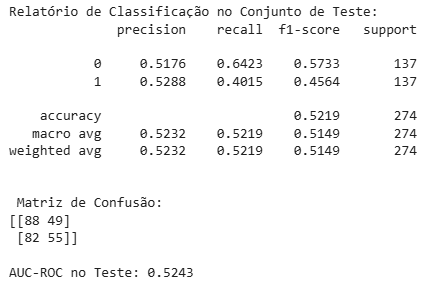

**Cenário 2:**

Considerando métrica `roc_auc`

* Métricas da Avaliação Inicial: LR, accuracy=0.513, f1_macro=0.512, roc_auc=0.522
* Modelo otimizado: grid_lr, ROC AUC: 0.529


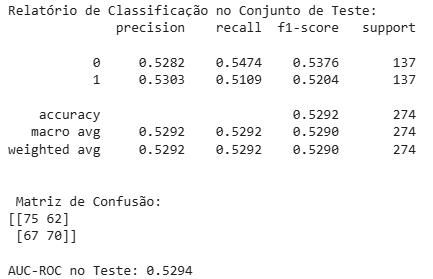





**Cenário 3:**

Considerando métrica `roc_auc`

* Métricas da Avaliação Inicial: LR, accuracy=0.511, f1_macro=0.508, roc_auc=0.515
* Modelo otimizado: grid_lr, ROC AUC: 0.526


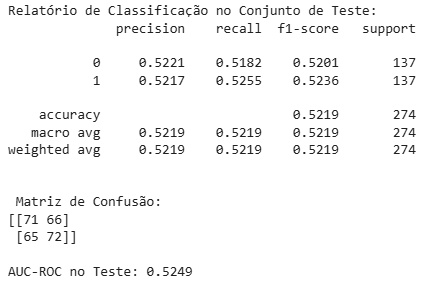




**Cenário 4:**

Considerando métrica `roc_auc`

* Métricas da Avaliação Inicial: SVM, accuracy=0.516, f1_macro=0.511, roc_auc=0.514
* Modelo otimizado: grid_svc, ROC AUC: 0.536


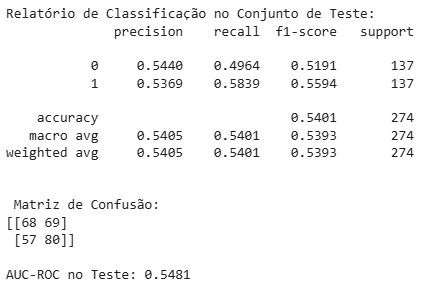




**Cenário 5:**

Considerando métrica `roc_auc`

* Métricas da Avaliação Inicial: KNN, accuracy=0.518, f1_macro=0.497, roc_auc=0.518
* Modelo otimizado: random_search_knn, ROC_AUC: 0.543


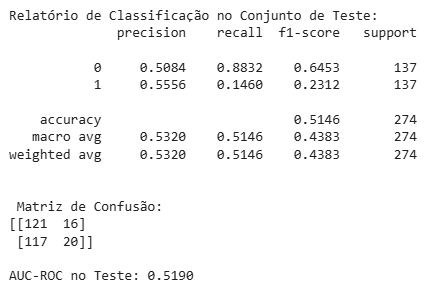


**Cenário 6:**

Considerando métrica `roc_auc`

* Métricas da Avaliação Inicial: RF_W2V, accuracy=0.493, f1_macro=0.491, roc_auc=0.503
* Modelo otimizado: modelo não foi otimizado devido ao valor baixo da métrica ROC_AUC


**Resultado da avaliação inicial dos modelos com Word2Vec**

LR_W2V: accuracy=0.497, f1_macro=0.332, roc_auc=0.472

KNN_W2V: accuracy=0.484, f1_macro=0.475, roc_auc=0.494

SVM_W2V: accuracy=0.500, f1_macro=0.352, roc_auc=0.470

RF_W2V: accuracy=0.493, f1_macro=0.491, roc_auc=0.503

LSVC_W2V: accuracy=0.486, f1_macro=0.437, roc_auc=0.461

**Cenário 7:**

Considerando métrica `roc_auc`

* Métricas da Avaliação Inicial: SVM_BERT, accuracy=0.4951, f1_macro=0.4915, roc_auc=0.4967
* Modelo otimizado: modelo não foi otimizado devido ao valor baixo da métrica ROC_AUC


**Resultado da avaliação inicial dos modelos com BERT**

LR_BERT: accuracy=0.4896, f1_macro=0.4877, roc_auc=0.4953

KNN_BERT: accuracy=0.4831, f1_macro=0.4820, roc_auc=0.4873

SVM_BERT: accuracy=0.4951, f1_macro=0.4915, roc_auc=0.4967

RF_BERT: accuracy=0.4876, f1_macro=0.4853, roc_auc=0.4934

**Cenário 8:**

Considerando métrica `roc_auc`

* Métricas da Avaliação Inicial: SVM, accuracy=0.531, f1_macro=0.520, roc_auc=0.528
* Modelo otimizado: random_search_svc, ROC_AUC: 0.541

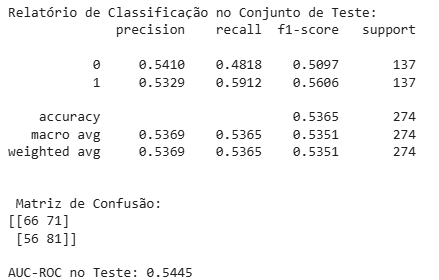




# **11) Gravação do melhor modelo**

A gravação não foi executada devido aos resultados insatisfatórios da modelagem.

In [ ]:
# Melhor modelo
melhor_modelo = nome_do_modelo_melhor_avaliado.best_estimator_

# Salva o modelo em disco
joblib.dump(melhor_modelo, 'nome_melhor_modelo.pkl')

# **12) Carga do melhor modelo**

A carga não foi executada devido aos resultados insatisfatórios da modelagem.

In [ ]:
# Carrega melhor modelo
modelo_carregado = joblib.load('nome_melhor_modelo.pkl')

# Faz previsões
y_pred = modelo_carregado.predict(X_test)


# **14) Considerações Finais**

### **Conclusão: Refutação da Hipótese e Diagnóstico da Inviabilidade do Dataset**

O objetivo deste trabalho era desenvolver um modelo robusto capaz de distinguir entre textos gerados por Modelos de Linguagem de Grande Escala (LLMs) e textos escritos por humanos. A hipótese central de que esta distinção poderia ser capturada por features linguísticas e estruturais foi **formalmente refutada** pelos resultados da modelagem.

A exaustiva avaliação de *cross-validation* demonstrou uma **falha sequencial e consistente** em todas as estratégias testadas:

1.  **Features de Frequência (TF-IDF):** Os classificadores obtiveram AUC-ROC no teste menor que 0.55 (0.5190, 0.5445, 0.5481), indicando que a frequência de palavras não possui valor preditivo;

2.  **Features Semânticas (Word2Vec e BERT/MPNet):** O uso de *embeddings* contextuais de alta dimensão (MPNet com 768 dimensões) também falhou, com AUC-ROC na avaliação com valores de 0.503 e 0.4967. Este resultado é o mais crítico, pois prova que, no nível semântico, os textos de IA e Humano são indistinguíveis neste conjunto de dados;

3.  **Features Híbridas e Meta-dados (Teste Final):** A combinação de todas as features disponíveis—métricas de estilo, `content_type` e TF-IDF também não produziu um resultado utilizável. O melhor score alcançado foi AUC-ROC na avaliação de 0.528 e no teste de 0.5445 (SVM), um valor que é marginalmente melhor que um chute aleatório.

### Resultado Final

A convergência de resultados desfavoráveis em todos os cenários leva a uma única conclusão: o dataset utilizado **apresenta baixo poder discriminatório** e é **inviável** para o propósito de detecção de autoria.

Este resultado sugere que a qualidade dos textos de IA presentes no conjunto é tão alta (ou a rotulagem é inconsistente) que as diferenças estilísticas e semânticas foram completamente invalidadas. A inexistência de uma feature preditiva robusta é a descoberta mais importante desta pesquisa.

## Sugestões para Pesquisas Futuras

1.  **Mudança de Abordagem de Detecção:** Futuros trabalhos devem abandonar a análise *feature-based* e migrar para modelos projetados especificamente para detecção de IA, como, por exemplo, *ensemble* de LLMs;

2.  **Meta-dados Não-Linguísticos:** Investigar a viabilidade de features baseadas em metadados externos, como data de criação, *timestamp* ou até mesmo estatísticas de imprevisibilidade do texto, que podem não ser afetadas pela qualidade da geração de linguagem.

Ao final, podemos supor que, em termos linguísticos, textos escritos por Inteligência Artificial apresentam grande semelhança com textos escritos por Humanos. Dessa forma, concluímos que a busca por features derivadas do comportamento estatístico, ou do processo de geração do texto, podem ser capazes de identificar padrões de artificialidade.